# Dyna-Q and Dyna-Q+

<img src="./images/planning.png" alt="environment" width="400"/>

## The Shortcut Maze Environment

In this maze environment, the goal is to reach the goal state (G) as fast as possible from the starting state (S). There are four actions (up, down, right, left) which take the agent deterministically from a state to the corresponding neighboring states, except when movement is blocked by a wall (denoted by grey) or the edge of the maze, in which case the agent remains where it is. The reward is +1 on reaching the goal state, 0 otherwise. On reaching the goal state G, the agent returns to the start state S to begin a new episode. This is a discounted, episodic task with $\gamma = 0.95$.

<img src="./images/shortcut_env.png" alt="environment" width="400"/>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from source.rl_glue import RLGlue
from source.agent import DynaQAgent, DynaQPlusAgent
from source.environment import ShortcutMazeEnvironment

Dyna-Q involves four basic steps:
1. Action selection: given an observation, select an action to be performed (here, using the $\epsilon$-greedy method).
2. Direct RL: using the observed next state and reward, update the action values (here, using one-step tabular Q-learning).
3. Model learning: using the observed next state and reward, update the model (here, updating a table as the environment is assumed to be deterministic).
4. Planning: update the action values by generating $n$ simulated experiences using certain starting states and actions (here, using the random-sample one-step tabular Q-planning method). This is also known as the 'Indirect RL' step. The process of choosing the state and action to simulate an experience with is known as 'search control'.

<img src="./images/dynaqAlgorithm.png" alt="environment" width="400"/>

In [2]:

def run_experiment(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters                     
    agent_info = {"num_states" : agent_parameters["num_states"],  # We pass the agent the information it needs. 
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes)) # for collecting metrics 
    log_data = {'planning_steps_all' : planning_steps_all}                     # that shall be plotted later

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 0.5') # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  

        for i in tqdm(range(num_runs)):
            agent_info['random_seed'] = i
            agent_info['planning_random_seed'] = i

            rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            for j in range(num_episodes):

                rl_glue.rl_start()                # We start an episode. Here we aren't using rl_glue.rl_episode()
                                                  # like the other assessments because we'll be requiring some 
                is_terminal = False               # data from within the episodes in some of the experiments here 
                num_steps = 0
                while not is_terminal:
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step 
                    num_steps += 1                                      # and return the reward and action taken.

                all_averages[idx][i][j] = num_steps

    log_data['all_averages'] = all_averages
    
    return log_data
    

def plot_steps_per_episode(data):
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(np.mean(all_averages[i], axis=0), label='Planning steps = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Episodes')
    plt.ylabel('Steps\nper\nepisode', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='grey', alpha=0.4)
    plt.show()

Planning steps :  0


100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.98it/s]


Planning steps :  5


100%|███████████████████████████████████████████| 30/30 [00:10<00:00,  2.90it/s]


Planning steps :  50


100%|███████████████████████████████████████████| 30/30 [01:05<00:00,  2.19s/it]


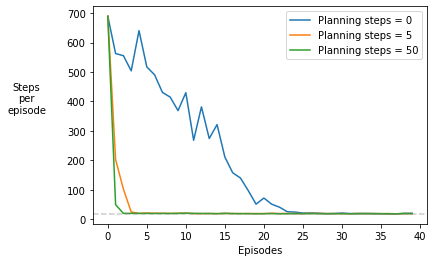

In [3]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_episodes" : 40,                 # The number of episodes per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 50]       # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

dataq = run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_steps_per_episode(dataq)   

As the number of planning steps increases, the number of episodes taken to reach the goal decreases rapidly. 

Great! Now let us see how Dyna-Q performs on the version of the maze in which a shorter path opens up after 3000 steps. The rest of the transition and reward dynamics remain the same. 

In [4]:
def run_experiment_with_state_visitations(env, agent, env_parameters, agent_parameters, exp_parameters, result_file_name):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}                     
    agent_info = {"num_states" : agent_parameters["num_states"],  
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    state_visits_before_change = np.zeros((len(planning_steps_all), num_runs, 54))  # For saving the number of
    state_visits_after_change = np.zeros((len(planning_steps_all), num_runs, 54))   #     state-visitations 
    cum_reward_all = np.zeros((len(planning_steps_all), num_runs, num_max_steps))   # For saving the cumulative reward
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 1')          # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  # We pass the agent the information it needs. 

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                state, _ = rl_glue.rl_start()  # We start the experiment. We'll be collecting the 
                is_terminal = False            # state-visitation counts to visiualize the learned policy
                if num_steps < env_parameters["change_at_n"]: 
                    state_visits_before_change[idx][run][state] += 1
                else:
                    state_visits_after_change[idx][run][state] += 1

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, state, action, is_terminal = rl_glue.rl_step()  
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[idx][run][num_steps] = cum_reward
                    if num_steps < env_parameters["change_at_n"]:
                        state_visits_before_change[idx][run][state] += 1
                    else:
                        state_visits_after_change[idx][run][state] += 1

    log_data['state_visits_before'] = state_visits_before_change
    log_data['state_visits_after'] = state_visits_after_change
    log_data['cum_reward_all'] = cum_reward_all
    
    return log_data

def plot_cumulative_reward(data_all, item_key, y_key, y_axis_label, legend_prefix, title):
    data_y_all = data_all[y_key]
    items = data_all[item_key]

    for i, item in enumerate(items):
        plt.plot(np.mean(data_y_all[i], axis=0), label=legend_prefix+str(item))

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel(y_axis_label, rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

Planning steps :  5


100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


Planning steps :  10


100%|███████████████████████████████████████████| 10/10 [00:20<00:00,  2.01s/it]


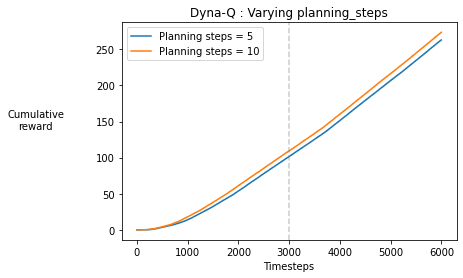

In [5]:

# Experiment parameters
experiment_parameters = {
    "num_runs" : 10,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [5, 10]      # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

dataq = run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q_shortcut_steps")    
plot_cumulative_reward(dataq, 'planning_steps_all', 'cum_reward_all', 'Cumulative\nreward', 'Planning steps = ', 'Dyna-Q : Varying planning_steps')

Now let's check the heatmap of the state visitations of the agent with `planning_steps=10` during training, before and after the shortcut opens up after 3000 timesteps.

In [6]:
def plot_state_visitations(data, plot_titles, idx):
    data_keys = ["state_visits_before", "state_visits_after"]
    positions = [211,212]
    titles = plot_titles
    wall_ends = [None,-1]

    for i in range(2):

        state_visits = data[data_keys[i]][idx]
        average_state_visits = np.mean(state_visits, axis=0)
        grid_state_visits = np.rot90(average_state_visits.reshape((6,9)).T)
        grid_state_visits[2,1:wall_ends[i]] = np.nan # walls
        #print(average_state_visits.reshape((6,9)))
        plt.subplot(positions[i])
        plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=1, cmap='viridis')
        plt.text(3+0.5, 0+0.5, 'S', horizontalalignment='center', verticalalignment='center')
        plt.text(8+0.5, 5+0.5, 'G', horizontalalignment='center', verticalalignment='center')
        plt.title(titles[i])
        plt.axis('off')
        cm = plt.get_cmap()
        cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([1., 0.0, 0.075, 1.])
    cbar = plt.colorbar(cax=cax)
    plt.show()

/tmp/ipykernel_32982/4256104304.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad('gray')


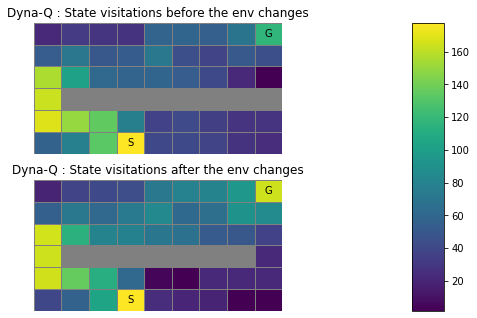

In [7]:
plot_state_visitations(dataq, ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 1)

The state visitation map looks almost the same before and after the shortcut opens. This means that the Dyna-Q agent hasn't quite discovered and started exploiting the new shortcut.

The motivation behind Dyna-Q+ is to give a bonus reward for actions that haven't been tried for a long time, since there is a greater chance that the dynamics for that actions might have changed.

In particular, if the modeled reward for a transition is $r$, and the transition has not been tried in $\tau(s,a)$ time steps, then planning updates are done as if that transition produced a reward of $r + \kappa \sqrt{ \tau(s,a)}$, for some small $\kappa$.

In [8]:

# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.5,
    "planning_steps" : [10]      
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQPlusAgent          # The agent

data_qplus = run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q+")

Planning steps :  10


100%|███████████████████████████████████████████| 30/30 [01:09<00:00,  2.31s/it]


In [9]:
def plot_cumulative_reward_comparison(data1, data2):

    cum_reward_q = data1['cum_reward_all'][1]
    cum_reward_qPlus = data2['cum_reward_all'][0]

    plt.plot(np.mean(cum_reward_qPlus, axis=0), label='Dyna-Q+')
    plt.plot(np.mean(cum_reward_q, axis=0), label='Dyna-Q')

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative\nreward', rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title('Average performance of Dyna-Q and Dyna-Q+ agents in the Shortcut Maze\n')
    plt.show()

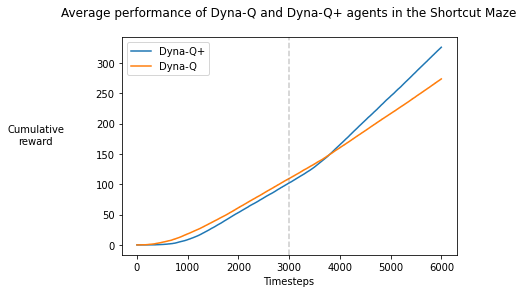

In [10]:
plot_cumulative_reward_comparison(dataq, data_qplus)

/tmp/ipykernel_32982/4256104304.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad('gray')


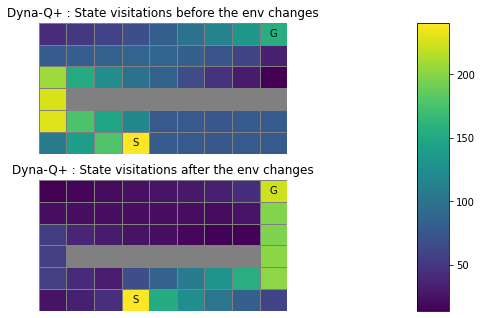

In [11]:
plot_state_visitations(data_qplus, ['Dyna-Q+ : State visitations before the env changes', 'Dyna-Q+ : State visitations after the env changes'], 0)

Before the shortcut opens up, like Dyna-Q, the Dyna-Q+ agent finds the sole, long path to the goal. But because the Dyna-Q+ agent keeps exploring, it succeeds in discovering the shortcut once it opens up, which leads to the goal faster. So the bonus reward heuristic is effective in helping the agent explore and find changes in the environment without degrading the performance. 